In [1]:
import csv
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
#from wordcloud import WordCloud
import tempfile

import preprocessor as p


from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import RSLPStemmer
import re
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
import itertools


%matplotlib inline

# Métodos de Pré Processamento 

In [2]:
def remove_stopwords(text):
     # remove punctuation
    chars = ['…','.', '/', ''', ''', '?', '!', '$', '%', '^', '&',
             '*', '(', ')', ' - ', '_', '+', '=', '@', ':',
             '\\', ',',
             ';', '~', '`', '<', '>', '|', '[', ']', '{', '}',
             '–', '“',
             '»', '«', '°', '’', '1', '2',
             '3', '4', '5', '6', '7', '8', '9', '0', 'https', 'http']
    for c in chars:
        text= text.replace(c,' ').lower()
    text = text.split()
    import nltk
    # Caso seja preciso mudar o idioma, basta inserir o idioma desejado no parâmetro.
    stopwords = nltk.corpus.stopwords.words('portuguese')
    content = [w for w in text if w.lower().strip() not in stopwords]

    return content

In [3]:
def tokenize(text):
    tokens = word_tokenize(text)
    porter = RSLPStemmer()
    tokens = [porter.stem(t) for t in tokens]
    tokens = [
                t for t in tokens
                    if len(t)> 2 and not t.isdigit()
    ]
    return tokens

In [4]:
def remove_emoji(text):
#    print(text)
   d=[]
   d = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
   d = d.sub(r'', text)
   return d

In [5]:
def remove_url(text):
   b=[]
   b = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
   return b

In [6]:
def remove_mentions(text):
   c=[]
   c = re.sub(r"(?:\@|https?\://)\S+", "", text)
   c = re.sub('[rt]', "", c)
   return c

In [7]:
def remove_hashtag(text):
    words = text.split()
    for i in words:
        if i.startswith('#'):
            words.remove(i)
    text = ''.join(text)
    return text

In [8]:
def aplica_steaming(text):
    stemmer = nltk.steam.RLSPStemmer()
    tweetsStemming = []
    for doc in text:
        comStemming = [srt(stemmer.steam(d)) for d in text.splip()]
        tweetsStemming.append(comStemming)

In [9]:
dataset = csv.reader(open('data/imdb-pt-br.csv', 'r', encoding='utf-8'))
list_docs = []
list_labels = []

for row in dataset:
    list_docs.append(row[1])
    list_labels.append(row[2])

In [10]:
print(list_docs[0], list_labels[0])

Este filme é excelente eu assisti a versão francesa. Existem muitas subtramas que geralmente prejudicam o todo, mas elas se desdobram muito bem e concorrem para o tema principal "descobrindo o verdadeiro eu". Na verdade, todo o filme, além de seu histórico, é a jornada para a descoberta de alguém ou de alguém. O rei é realmente um "bom monarca pacifista" tentando travar uma "guerra para acabar com todas as guerras" ou ele é apenas um perturbado e sedento sanguinário? Ele é um verdadeiro rei, afinal? A atendente da rainha-mãe é apenas uma marionete voluptuosa, impulsionada pela carreira e sem cabeça, ou uma pessoa de pensamento aguçado e ousada? A dama / concubina perceberá quem é verdadeiramente o rei? O que há entre o rei e o antigo chanceler? Qual é o segredo que todo mundo sabe, mas não vai contar? Qual é a verdadeira razão pela qual o assassino deixou seu "emprego"? Subtramas das quais eu não gosto particularmente são bem tratadas e mantêm uma observação até o final. Cenas são bem 

In [11]:
count_neg=0
count_pos=0

list_neg=[]
list_pos=[]

documents = []
labels    = []

doc = []
with open('data/imdb-pt-br.csv','r', encoding='utf-8') as csvfile:
    reader = csv.reader(csvfile, delimiter =',')
    for row in reader:
        if row[2]=='neg':
            count_neg+=1
            list_neg.append(row[2])
        else:
            count_pos+=1
            list_pos.append(row[2])
            
        documents.append(row[1])
        labels.append(row[2])

In [12]:
clean_documents = []
for doc in documents:
    #usando as funcões da tweetpreprocess
    tweetsLimpos = p.clean(doc)
    tweetsPreProcessados = remove_stopwords(tweetsLimpos)
    #tokenizado = tokenize(tweetsPreProcessados)
    document = ' '.join(tweetsPreProcessados)
    clean_documents.append(document)

    
tokenizado_documents = []
for doc in clean_documents:
    tokenizado = tokenize(doc)
    document = ' '.join(tokenizado)
    tokenizado_documents.append(document)

In [13]:
print(tokenizado_documents[0])

film excel assist vers franc exist muit subtram geral prejudic tod desdobr bem concorr tem princip descobr verd verdad tod film além histór jorn descobert alguém alguém rei real bom monarc pacif tent trav guerr acab tod guerr apen perturb sedent sanguin verd rei afinal atend rainha-mã apen marionet volupt impulsion carr cabeç pesso pens aguç ous dam concubin perceb verdade rei rei antig chancel segred tod mund sab vai cont verd assassin deiu empreg subtram qual gost particul bem trat mantêm observ final cen bem trabalh cgi encaix perfeit exager suspens mant adequad pront taref muit sorris problem cerebr assim dev comport cort reil reclam dam concubin film real moment super-herol film chin real envergonh papel hollywood coloss gladi etc


# Matrix de Confusão

In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Classe Real')
    plt.xlabel('Classe Predita')

# DESCRIÇÃO DA BASE DE DADOS

1999
2001


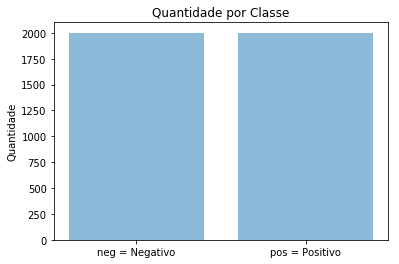

In [15]:
objects = ('neg = Negativo', 'pos = Positivo')
y_pos = np.arange(len(objects))
performance = [count_neg, count_pos]

plt.bar(y_pos, performance, align='center',alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Quantidade')
plt.title('Quantidade por Classe')

print(count_neg)
print(count_pos)

plt.show()

# TF-IDF

In [16]:
vectorizer = TfidfVectorizer(use_idf=True)
X = vectorizer.fit_transform(tokenizado_documents)
y = labels

# MÉTRICAS: ACURÁCIA, F1, RECALL, PRECISION

In [17]:
def train(classifier, X, y, class_names):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=81)
    
    ##TREINANDO MEU ALGORITMO
    classifier.fit(X_train, y_train)
    
    ##Predicoes para medição da Acurácia
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    
    print("Acurracia: %s" % classifier.score(X_test,y_test))
    print("F1: %s" % str(f1_score(y_test, y_pred, average=None )))
    print("Recall: %s"% str(recall_score(y_test, y_pred, average=None)))
    print("Precision: %s" % str(precision_score(y_test, y_pred, average=None)))
    
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, title='Matriz de Confusao')
    
    plt.show()
    
    return classifier

# MultinomialNB

Acurracia: 0.91
F1: [0.91 0.91]
Recall: [0.9  0.92]
Precision: [0.92 0.9 ]
Confusion matrix, without normalization
[[186  20]
 [ 16 178]]


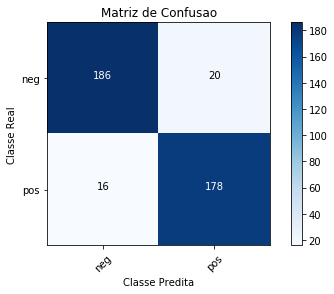

MultinomialNB(alpha=0.05, class_prior=None, fit_prior=True)

In [23]:
train(MultinomialNB(alpha=0.05), X, y, ['neg','pos'])

# Suport Vector Machine 

Acurracia: 0.88
F1: [0.88 0.88]
Recall: [0.84 0.92]
Precision: [0.92 0.85]
Confusion matrix, without normalization
[[174  32]
 [ 16 178]]


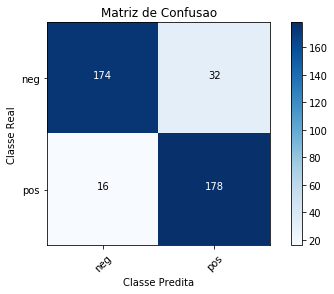

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [24]:
train(svm.SVC(kernel='linear', C=1.0), X,y, ['neg','pos'])

# SGDClassifier

c:\users\jarde\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Acurracia: 0.8875
F1: [0.89 0.89]
Recall: [0.85 0.92]
Precision: [0.92 0.86]
Confusion matrix, without normalization
[[176  30]
 [ 15 179]]


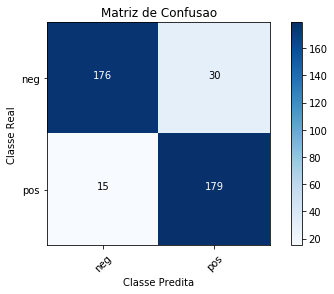

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [25]:
train(SGDClassifier(alpha=0.0001), X,y, ['neg','pos'])

In [26]:
from multiscorer import MultiScorer
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score 
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer


models = [MultinomialNB(alpha=0.05), svm.SVC(kernel='linear', C=1.0), SGDClassifier(alpha=0.0001)]
names = ['MultinomialNB', 'SVM', 'SGDC']

scorer = MultiScorer({
    'Accuracy' : (accuracy_score, {}),
    'Precision' : (precision_score, {'pos_label': 3, 'average':'macro'}),
    'Recall' : (recall_score, {'pos_label': 3, 'average':'macro'})
})

for model, name in zip(models, names):
    print (name)
    start = time.time()

    cross_val_score(model, X, y,scoring=scorer, cv=5)
    results = scorer.get_results()

    for metric_name in results.keys():
        average_score = np.average(results[metric_name])
        print('%s : %f' % (metric_name, average_score))

    print ('time :', time.time() - start, '\n\n')
    
#    for metric_name in results.keys():
#        average_score = np.average(results[metric_name])
#        print('%s : %f' % (metric_name, average_score))
#    
#    print ('time :', time.time() - start, '\n\n')

#scores_MultinomialNB_classifier = cross_validate(MultinomialNB_classifier, X, y, cv=cv, scoring=scoring)
#print (scores.keys(), 
#       scores_MultinomialNB_classifier)

#scores_SVM_classifier = cross_validate(SVM_classifier, X, y, cv=cv, scoring=scoring)
#print (scores.keys(),
#       scores_SVM_classifier)

#scores_SGDC_Classifier = cross_val_score(SGDC_Classifier, X, y, cv=cv, score=scoring)
#print (scores_SGDC_Classifier)

MultinomialNB


c:\users\jarde\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\metrics\classification.py:1052: UserWarning: Note that pos_label (set to 3) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
c:\users\jarde\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\metrics\classification.py:1052: UserWarning: Note that pos_label (set to 3) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
c:\users\jarde\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\metrics\classification.py:1052: UserWarning: Note that pos_label (set to 3) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
c:\users\jarde\appdata\local\programs\python\python3

Accuracy : 0.725748
Precision : 0.736134
Recall : 0.725800
time : 8.361598491668701 


SVM


c:\users\jarde\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\metrics\classification.py:1052: UserWarning: Note that pos_label (set to 3) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


Accuracy : 0.762500
Precision : 0.769699
Recall : 0.762537
time : 70.52245926856995 


SGDC


c:\users\jarde\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
c:\users\jarde\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\metrics\classification.py:1052: UserWarning: Note that pos_label (set to 3) is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


Accuracy : 0.770752
Precision : 0.777294
Recall : 0.770784
time : 0.29221510887145996 


